<a href="https://colab.research.google.com/github/ru1120/113_DLBOI/blob/main/112011566_HW4_Restnet_18.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Library

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import random
import time
import torch
import torch.nn as nn
import torch.optim as optims

from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms.functional import InterpolationMode

In [ ]:
# 检查是否有可用的GPU
if torch.cuda.is_available():
    device = torch.device('cuda')  # 使用GPU
else:
    device = torch.device('cpu')    # 使用CPU
gpu_count = torch.cuda.device_count()

print("Using", gpu_count, "GPUs")
print("CUDA is available:", torch.cuda.is_available())

Using 0 GPUs
CUDA is available: False


In [ ]:
# train loop
def train_one_epoch(model, device, criterion, optimizer, train_data_loader):
    epoch_loss = []
    epoch_acc = []
    start_time = time.time()

    model.train()

    for batch_idx, (images, labels) in enumerate (train_data_loader):#再把影像load進dataset時，images 是一个形状为 [64, channels, height, width]的张量，表示 64 张图片的数据。labels是一个形状为 [64] 的张量，表示 64 张图片对应的标签。
        images = images.to(device)
        labels = labels.to(device).float()
        optimizer.zero_grad()
        preds = model(images)  #將影像丟入到模型進行訓練

        loss = criterion(preds, labels.unsqueeze(1))  # labels.unsqueeze(1):labels = torch.tensor([1, 0, 1])轉為labels = torch.tensor([[1], [0], [1]]) 接著去對每個pred計算Loss並取平均得出一個總體loss



        # Calculating Loss
        epoch_loss.append(loss.item())#儲存每個batch的loss

        # Calculating Metrics
        predicts = (preds > 0.5).float()   #將輸出結果轉為0或1
        predicts = predicts.view(-1)    #將張量轉為1維
        predicts = predicts.detach().cpu().numpy()  #將數據提取出來 去掉梯度等維度 變成純資料
        labels = labels.detach().cpu().numpy()
        acc = accuracy_score(labels, predicts)

        epoch_acc.append(acc)

        # Backpropagation
        loss.backward()
        optimizer.step()# 參數更新

    # Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time

    epoch_loss = np.mean(epoch_loss)  #計算一個epoch裡的平均損失(加總每個batch並取平均)
    epoch_acc = np.mean(epoch_acc) * 100

    return epoch_loss, epoch_acc, total_time

# validation loop
def val_one_epoch(model, device, criterion, val_data_loader, best_acc, save):
    epoch_loss = []
    epoch_acc = []
    start_time = time.time()

    model.eval()

    with torch.no_grad():#不記錄張量
        for images, labels in val_data_loader:
            images = images.to(device)
            labels = labels.to(device).float()
            preds = model(images)

            # Calculating Loss
            loss = criterion(preds, labels.unsqueeze(1))
            epoch_loss.append(loss.item())

            # Calculating Metrics
            predicts = (preds > 0.5).float()
            predicts = predicts.view(-1)
            predicts = predicts.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()
            acc = accuracy_score(labels, predicts)
            epoch_acc.append(acc)

    # Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time

    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc) * 100

    # Saving best model
    if epoch_acc > best_acc:
        best_acc = epoch_acc
        torch.save(model.state_dict(), f"{save}.pth")

    return epoch_loss, epoch_acc, total_time, best_acc

# evaluate loop (test loop)
def evaluate(model, device, model_path, test_loader):
    try:
        model.load_state_dict(torch.load(model_path))
        print("Model weights loaded successfully.")
    except Exception as e:
        print("Warning: Failed to load model weights. Using randomly initialized weights instead.")
        print(e)

    model.to(device)
    model.eval()

    test_loss = []
    test_acc = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device).float()

            # Forward pass
            preds = model(images)

            # Calculating loss
            loss = criterion(preds, labels.unsqueeze(1))
            test_loss.append(loss.item())

            # Calculating accuracy
            predicts = (preds > 0.5).float()
            predicts = predicts.view(-1)
            predicts = predicts.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()
            acc = accuracy_score(labels, predicts)
            test_acc.append(acc)

    # Overall test results
    avg_test_loss = np.mean(test_loss)
    avg_test_acc = np.mean(test_acc) * 100

    print(f"Test Accuracy: {avg_test_acc:.2f}%")
    print(f"Test Loss: {avg_test_loss:.4f}")

    return avg_test_loss, avg_test_acc

# Data Preparation

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# define folder path for each set
train_path = '/content/drive/MyDrive/HW3_訓練資料/train'
test_path = '/content/drive/MyDrive/HW3_訓練資料/test'
val_path = '/content/drive/MyDrive/HW3_訓練資料/val'

# define transformation
train_transform = transforms.Compose([
    transforms.Resize((224, 224), interpolation=InterpolationMode.BICUBIC),# resize圖像跟把圖像放大變得更清晰
    transforms.Grayscale(num_output_channels=1),# 將圖像轉為灰階圖 Y=0.2989×R+0.5870×G+0.1140×B
    transforms.ToTensor(),#將pixel歸一成[01]
])

common_transform = transforms.Compose([
    transforms.Resize((224, 224), interpolation=InterpolationMode.BICUBIC),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
])

# create datasets
train_dataset = datasets.ImageFolder(train_path, transform=train_transform) #讀取數據並對數據進行預處理 transform=train_transform具有代碼可讀性以及指定傳入哪個參數

# 获取标签

test_dataset = datasets.ImageFolder(test_path, transform=common_transform)


val_dataset = datasets.ImageFolder(val_path, transform=common_transform)


# create dataloaders
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)  #對數據進行批次處理
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# Model

In [ ]:
import os
from torchvision import models

checkpoint_path = 'model_checkpoint.pth'
torch.cuda.empty_cache()





import torch.nn.init as init

class ResNet18WithSigmoid(nn.Module):
    def __init__(self):
        super(ResNet18WithSigmoid, self).__init__()

        # 加载预训练的 ResNet18 模型
        self.model = models.resnet18(pretrained=True)

        # 修改第一层卷积层，使其适应单通道输入（如 X 光图像）
        self.model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)


        # 修改分类层为一个输出节点，适应二分类任务
        num_features = self.model.fc.in_features
        self.model.fc = nn.Linear(num_features, 1)  # 二分类任務的輸出



    def forward(self, x):
        # 前向传播，并使用 sigmoid 激活函数得到二分类概率
        x = self.model(x)
        return torch.sigmoid(x)
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        BCE_loss = nn.BCEWithLogitsLoss()(inputs, targets)
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss
        return F_loss

# 实例化并将模型转移到设备
model = ResNet18WithSigmoid().to(device)

print(model)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 121MB/s]


ResNet18WithSigmoid(
  (model): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True,

# Loop

In [ ]:
# hyperparameter
lr = 0.0001
weight_decay = 0.0001
optimizer = optims.Adam(model.parameters(), lr=lr, weight_decay = weight_decay)
lr_scheduler = optims.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=5, mode='max')
epochs = 15
criterion = FocalLoss()

save = 'model'


In [ ]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

best_acc = 0.0
output_list = []
start_epoch=0 #加上checkpoint 方便中斷後再重新下次從未完成的地方開始

if os.path.exists(checkpoint_path):#checkpoint
    print("Loading checkpoint...")
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch']
    print(f"Checkpoint loaded, resuming from epoch {start_epoch}")
    output=checkpoint['previous']
    for i in range(0,len(output)):
      print(output[i])

else:
    print("No checkpoint found, training from epoch 0.")


for epoch in range(start_epoch,epochs):
    train_loss, train_acc, train_time = train_one_epoch(model, device, criterion, optimizer, train_loader)
    val_loss, val_acc, val_time, best_acc = val_one_epoch(model, device, criterion, val_loader, best_acc, save)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    total_time = train_time + val_time
    output_str = f"Epoch {epoch+1}/{epochs} - train_loss: {train_loss:.4f} - train_acc: {train_acc:.2f}% - val_loss: {val_loss:.4f} - val_acc: {val_acc:.2f}% - time: {total_time:.2f}s"
    output_list.append(output_str)
    print(output_str)
    lr_scheduler.step(val_acc)

    torch.save({                    #保存每一次epoch的資料 避免暫停後還要重新開始跑
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'previous': output_list
        }, checkpoint_path)

No checkpoint found, training from epoch 0.
Epoch 1/15 - train_loss: 0.1085 - train_acc: 88.71% - val_loss: 0.3467 - val_acc: 50.00% - time: 983.63s
Epoch 2/15 - train_loss: 0.0846 - train_acc: 97.43% - val_loss: 0.2924 - val_acc: 50.00% - time: 619.96s
Epoch 3/15 - train_loss: 0.0815 - train_acc: 98.90% - val_loss: 0.3049 - val_acc: 56.25% - time: 619.66s
Epoch 4/15 - train_loss: 0.0800 - train_acc: 99.51% - val_loss: 0.3012 - val_acc: 50.00% - time: 621.53s
Epoch 5/15 - train_loss: 0.0800 - train_acc: 99.66% - val_loss: 0.2258 - val_acc: 75.00% - time: 618.60s
Epoch 6/15 - train_loss: 0.0792 - train_acc: 99.90% - val_loss: 0.1773 - val_acc: 81.25% - time: 623.43s
Epoch 7/15 - train_loss: 0.0797 - train_acc: 99.95% - val_loss: 0.1744 - val_acc: 81.25% - time: 627.64s
Epoch 8/15 - train_loss: 0.0789 - train_acc: 99.95% - val_loss: 0.1588 - val_acc: 87.50% - time: 615.27s
Epoch 9/15 - train_loss: 0.0789 - train_acc: 99.95% - val_loss: 0.2011 - val_acc: 75.00% - time: 622.38s
Epoch 10/15

# Graph

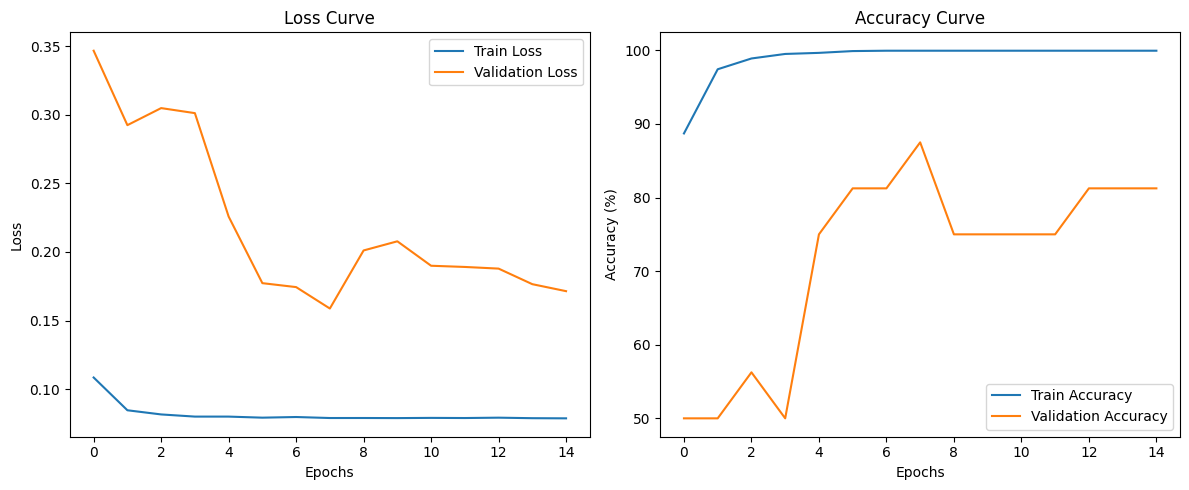

In [ ]:
plt.figure(figsize=(12, 5))

# loss graph
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# accuracy graph
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

# show
plt.tight_layout()
plt.show()

# Evaluate

In [ ]:
model_path = 'model.pth'
avg_test_loss, avg_test_acc = evaluate(model, device, model_path, test_loader)
if os.path.exists(checkpoint_path):
    os.remove(checkpoint_path)
    print(f"{checkpoint_path} has been deleted.")

<ipython-input-3-39e6b9d80d50>:87: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Model weights loaded successfully.
Test Accuracy: 87.59%
Test Loss: 0.1206
model_checkpoint.pth has been deleted.
